<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/keras_model_add_loss_decompose_loss_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# https://deeplizard.com/learn/video/lu7TCu7HeYc

from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pickle
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import tensorflow as tf
from numpy import linalg as LA

from tensorflow.keras import backend as K

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 Hidden_dense2 (Dense)          (None, 1)            2           ['input_2[0][0]']                
                                                                                                  
 Hidden_dense1 (Dense)          (None, 1)            2           ['input_2[0][0]']                
                                                                                                  
 Hidden_dense22 (Dense)         (None, 1)            1           ['Hidden_dense2[0][0]']          
                                                                                            

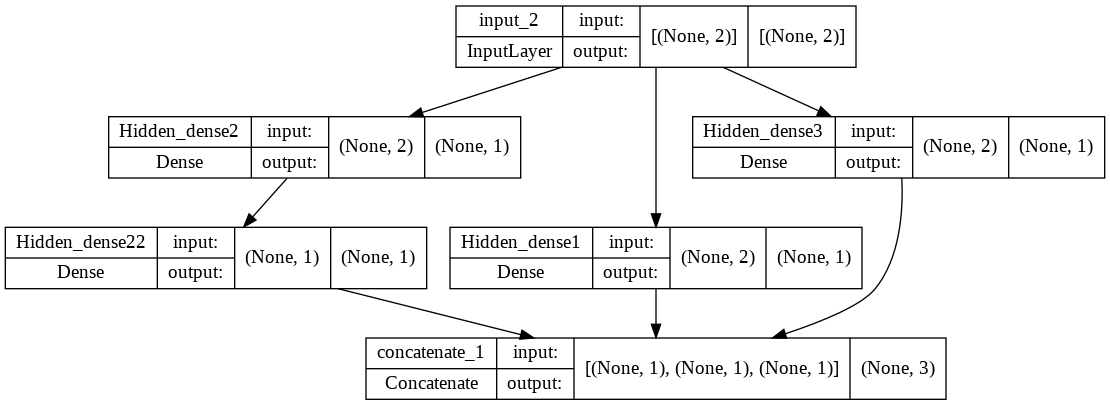

In [7]:
np.random.seed(123)
X=np.random.randn(100,2)
beta=np.array([[1.,2.,3],[4.,5.,6]])
Y=X.dot(beta)
Y1=Y[:,0]
Y2=Y[:,1]
Y3=Y[:,2]

tf.random.set_seed(123)

from keras.layers import Lambda

def custom_mse2(  y_true, y_pred):
    # calculating squared difference between target and predicted values 
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    # loss1 = loss * [0, 1]          # (batch_size, 2)
    # loss=K.mean(loss)
    return loss

inputs = Input(shape=(2,) )
output1  = Dense(1, activation='linear', name="Hidden_dense1",  use_bias=False)(inputs)
output2  = Dense(1, activation='linear',   name="Hidden_dense2",  use_bias=False)(inputs)
output22  = Dense(1, activation='linear',   name="Hidden_dense22",  use_bias=False)(output2)
output3  = Dense(1, activation='linear',   name="Hidden_dense3",  use_bias=False)(inputs)


# add_cost =  tf.math.reduce_mean(K.square(output2-output22))
add_cost =  1*tf.math.reduce_mean(K.square(inputs))

merge_layer = keras.layers.concatenate([output1, output22, output3])

model=Model(inputs , merge_layer )
# model.add_loss(add_cost)

opt = tf.keras.optimizers.Adam(learning_rate=0.02)

model.compile(optimizer=opt, loss=custom_mse2)
model.summary();

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, )



In [8]:
from  tensorflow.keras.callbacks   import Callback;
class LearningRateReducerCb(Callback):

    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        if epoch % 5 == 0:
            if epoch <=200:  
                new_lr = max(old_lr * 0.98, 0.0003)
            elif (epoch > 200) & (epoch <=2900): 
                new_lr = max(old_lr * 0.97, 0.00001)
            self.model.optimizer.lr.assign(new_lr)
        if epoch % 100 == 0:
            print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
            print("End epoch {} of train loss: {}".format(epoch, logs["loss"]))
#         if epoch == 4999:
#             print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
#             print("End epoch {} of train loss: {}".format(epoch, logs["loss"]))
epochs = 600
batch_size = int(X.shape[0]/5)
print(batch_size)
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X, Y), shuffle=False, callbacks=[LearningRateReducerCb()])

20

Epoch: 0. Reducing Learning Rate from 0.019999999552965164 to 0.019600000232458115
End epoch 0 of train loss: 37.035682678222656

Epoch: 100. Reducing Learning Rate from 0.01335216499865055 to 0.013085122220218182
End epoch 100 of train loss: 0.20681260526180267

Epoch: 200. Reducing Learning Rate from 0.00891401432454586 to 0.008735734038054943
End epoch 200 of train loss: 0.0012977421283721924

Epoch: 300. Reducing Learning Rate from 0.004897366277873516 to 0.004750445485115051
End epoch 300 of train loss: 1.3278212463774253e-05

Epoch: 400. Reducing Learning Rate from 0.002663161838427186 to 0.002583267167210579
End epoch 400 of train loss: 4.3878571887034923e-07

Epoch: 500. Reducing Learning Rate from 0.0014482128899544477 to 0.0014047665754333138
End epoch 500 of train loss: 3.840574791524887e-08


In [12]:

layer = model.get_layer('Hidden_dense1')
coef1=layer.get_weights()[0].T
print('coef1 estimate','\n', coef1 , '\n')

layer = model.get_layer('Hidden_dense2')
coef2=layer.get_weights()[0].T
print('coef2 estimate','\n', coef2 , '\n')

layer = model.get_layer('Hidden_dense22')
coef22=layer.get_weights()[0].T
print('coef22 estimate','\n', coef22 , '\n')

layer = model.get_layer('Hidden_dense3')
coef3=layer.get_weights()[0].T
print('coef3 estimate','\n', coef3 , '\n')

# layer = model.get_layer('B_matrix')
# BZ=layer.get_weights()[0].T
# print('B_matrix','\n',BZ, '\n')

# # layer = model.get_layer('C_matrix')
# # CZ=(layer.get_weights()[0]).T
# # print('CT_matrix','\n', CZ, '\n')

# layer = model.get_layer('G_matrix')
# GZ=(layer.get_weights()[0].T)
# print('GT_matrix ','\n', GZ, '\n')

coef1 estimate 
 [[1 4]] 

coef2 estimate 
 [[-1.1568 -2.8921]] 

coef22 estimate 
 [[-1.7289]] 

coef3 estimate 
 [[3 5.9999]] 



In [14]:
ynew = model.predict(X)
ynew.shape

(100, 3)

In [16]:
ynew = model.predict(X)

df_model=pd.DataFrame(np.c_[ynew,Y], columns=['x1_model','x2_model', 'x3_model',  'x1_true','x2_true','x3_true'])
df_model['err_x1']=df_model['x1_model']-df_model['x1_true']
df_model['err_x2']=df_model['x2_model']-df_model['x2_true']
df_model['err_x3']=df_model['x3_model']-df_model['x3_true']

df_model['err_x1_sq']=df_model['err_x1']*df_model['err_x1']
df_model['err_x2_sq']=df_model['err_x2']*df_model['err_x2']
df_model['err_x3_sq']=df_model['err_x3']*df_model['err_x3']
pd.reset_option('display.float_format')
df_model.describe()


,x1_model,x2_model,x3_model,x1_true,x2_true,x3_true,err_x1,err_x2,err_x3,err_x1_sq,err_x2_sq,err_x3_sq
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02
mean,-0.362311,-0.354739,-0.347142,-0.362313,-0.354739,-0.347166,0.000002,2.439383e-07,0.000024,1.998496e-10,3.794322e-12,2.691381e-08
std,4.622649,6.032695,7.494257,4.622661,6.032697,7.494384,0.000014,1.942303e-06,0.000163,2.776579e-10,5.875264e-12,3.766479e-08
min,-12.727160,-15.761232,-18.794798,-12.727201,-15.761237,-18.795273,-0.000029,-4.672058e-06,-0.000343,8.545852e-15,7.750807e-17,4.329860e-15
25%,-3.002666,-3.493170,-4.143269,-3.002681,-3.493172,-4.143379,-0.000007,-9.889901e-07,-0.000081,1.557380e-11,3.031989e-13,1.931643e-09
50%,-0.326389,-0.421912,-0.353309,-0.326387,-0.421913,-0.353347,0.000001,2.099031e-07,0.000017,8.207572e-11,1.523281e-12,1.085594e-08
75%,2.634991,3.532709,4.342653,2.634988,3.532710,4.342836,0.000011,1.424319e-06,0.000125,2.955726e-10,4.734662e-12,4.004247e-08
max,11.105452,15.345787,19.738291,11.105480,15.345791,19.738507,0.000041,6.221185e-06,0.000475,1.652043e-09,3.870314e-11,2.259600e-07


In [19]:
np.random.seed(123)
X=np.random.randn(100,2)
beta=np.array([[1.,2.,3],[4.,5.,6]])
Y=X.dot(beta)
Y1=Y[:,0]
Y2=Y[:,1]
Y3=Y[:,2]

tf.random.set_seed(123)

from keras.layers import Lambda

def custom_mse2(  y_true, y_pred):
    # calculating squared difference between target and predicted values 
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    # loss1 = loss * [0, 1]          # (batch_size, 2)
    # loss=K.mean(loss)
    return loss

inputs = Input(shape=(2,) )
output1  = Dense(1, activation='linear', name="Hidden_dense1",  use_bias=False)(inputs)
output2  = Dense(1, activation='linear',   name="Hidden_dense2",  use_bias=False)(inputs)
output22  = Dense(1, activation='linear',   name="Hidden_dense22",  use_bias=False)(output2)
output3  = Dense(1, activation='linear',   name="Hidden_dense3",  use_bias=False)(inputs)


# add_cost =  tf.math.reduce_mean(K.square(output2-output22))
add_cost =  1*tf.math.reduce_mean(K.square(inputs))

merge_layer = keras.layers.concatenate([output1, output22, output3])

model=Model(inputs , merge_layer )
model.add_loss(add_cost)

opt = tf.keras.optimizers.Adam(learning_rate=0.02)

model.compile(optimizer=opt, loss=custom_mse2)
model.summary()

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True);



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 Hidden_dense2 (Dense)          (None, 1)            2           ['input_5[0][0]']                
                                                                                                  
 Hidden_dense1 (Dense)          (None, 1)            2           ['input_5[0][0]']                
                                                                                                  
 Hidden_dense22 (Dense)         (None, 1)            1           ['Hidden_dense2[0][0]']          
                                                                                            

In [20]:
from  tensorflow.keras.callbacks   import Callback;
class LearningRateReducerCb(Callback):

    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        if epoch % 5 == 0:
            if epoch <=200:  
                new_lr = max(old_lr * 0.98, 0.0003)
            elif (epoch > 200) & (epoch <=2900): 
                new_lr = max(old_lr * 0.97, 0.00001)
            self.model.optimizer.lr.assign(new_lr)
        if epoch % 100 == 0:
            print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
            print("End epoch {} of train loss: {}".format(epoch, logs["loss"]))
#         if epoch == 4999:
#             print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
#             print("End epoch {} of train loss: {}".format(epoch, logs["loss"]))
epochs = 600
batch_size = int(X.shape[0]/5)
print(batch_size)
history = model.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X, Y), shuffle=False, callbacks=[LearningRateReducerCb()])

20

Epoch: 0. Reducing Learning Rate from 0.019999999552965164 to 0.019600000232458115
End epoch 0 of train loss: 38.14320373535156

Epoch: 100. Reducing Learning Rate from 0.01335216499865055 to 0.013085122220218182
End epoch 100 of train loss: 1.3143360614776611

Epoch: 200. Reducing Learning Rate from 0.00891401432454586 to 0.008735734038054943
End epoch 200 of train loss: 1.1088212728500366

Epoch: 300. Reducing Learning Rate from 0.004897366277873516 to 0.004750445485115051
End epoch 300 of train loss: 1.1075366735458374

Epoch: 400. Reducing Learning Rate from 0.002663161838427186 to 0.002583267167210579
End epoch 400 of train loss: 1.1075239181518555

Epoch: 500. Reducing Learning Rate from 0.0014482128899544477 to 0.0014047665754333138
End epoch 500 of train loss: 1.1075234413146973


In [21]:

layer = model.get_layer('Hidden_dense1')
coef1=layer.get_weights()[0].T
print('coef1 estimate','\n', coef1 , '\n')

layer = model.get_layer('Hidden_dense2')
coef2=layer.get_weights()[0].T
print('coef2 estimate','\n', coef2 , '\n')

layer = model.get_layer('Hidden_dense22')
coef22=layer.get_weights()[0].T
print('coef22 estimate','\n', coef22 , '\n')

layer = model.get_layer('Hidden_dense3')
coef3=layer.get_weights()[0].T
print('coef3 estimate','\n', coef3 , '\n')

# layer = model.get_layer('B_matrix')
# BZ=layer.get_weights()[0].T
# print('B_matrix','\n',BZ, '\n')

# # layer = model.get_layer('C_matrix')
# # CZ=(layer.get_weights()[0]).T
# # print('CT_matrix','\n', CZ, '\n')

# layer = model.get_layer('G_matrix')
# GZ=(layer.get_weights()[0].T)
# print('GT_matrix ','\n', GZ, '\n')

coef1 estimate 
 [[1 4]] 

coef2 estimate 
 [[-1.1568 -2.8921]] 

coef22 estimate 
 [[-1.7289]] 

coef3 estimate 
 [[3 5.9999]] 



In [22]:
ynew = model.predict(X)

df_model=pd.DataFrame(np.c_[ynew,Y], columns=['x1_model','x2_model', 'x3_model',  'x1_true','x2_true','x3_true'])
df_model['err_x1']=df_model['x1_model']-df_model['x1_true']
df_model['err_x2']=df_model['x2_model']-df_model['x2_true']
df_model['err_x3']=df_model['x3_model']-df_model['x3_true']

df_model['err_x1_sq']=df_model['err_x1']*df_model['err_x1']
df_model['err_x2_sq']=df_model['err_x2']*df_model['err_x2']
df_model['err_x3_sq']=df_model['err_x3']*df_model['err_x3']
pd.reset_option('display.float_format')
df_model.describe()


,x1_model,x2_model,x3_model,x1_true,x2_true,x3_true,err_x1,err_x2,err_x3,err_x1_sq,err_x2_sq,err_x3_sq
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02
mean,-0.362311,-0.354739,-0.347142,-0.362313,-0.354739,-0.347166,0.000002,2.439383e-07,0.000024,1.998496e-10,3.794322e-12,2.691381e-08
std,4.622649,6.032695,7.494257,4.622661,6.032697,7.494384,0.000014,1.942303e-06,0.000163,2.776579e-10,5.875264e-12,3.766479e-08
min,-12.727160,-15.761232,-18.794798,-12.727201,-15.761237,-18.795273,-0.000029,-4.672058e-06,-0.000343,8.545852e-15,7.750807e-17,4.329860e-15
25%,-3.002666,-3.493170,-4.143269,-3.002681,-3.493172,-4.143379,-0.000007,-9.889901e-07,-0.000081,1.557380e-11,3.031989e-13,1.931643e-09
50%,-0.326389,-0.421912,-0.353309,-0.326387,-0.421913,-0.353347,0.000001,2.099031e-07,0.000017,8.207572e-11,1.523281e-12,1.085594e-08
75%,2.634991,3.532709,4.342653,2.634988,3.532710,4.342836,0.000011,1.424319e-06,0.000125,2.955726e-10,4.734662e-12,4.004247e-08
max,11.105452,15.345787,19.738291,11.105480,15.345791,19.738507,0.000041,6.221185e-06,0.000475,1.652043e-09,3.870314e-11,2.259600e-07


In [26]:
np.mean(X*X) - 1.1075234413146973

9.060701011698313e-08